In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

%load_ext autoreload
%autoreload 2

In [3]:
def load_train_images(directory):
    xs = []
    for filename in os.listdir(directory):
        im = Image.open(os.path.join(directory, filename), 'r')
        X = np.array(im.crop((0,0,96,96)).getdata()).reshape(27648,)
        xs.append(X)
    Xtr = np.array(xs)
    del X
    return Xtr

In [4]:
train_images_dir = 'train_images'
X_train = load_train_images(train_images_dir)


In [5]:
print(X_train.shape)

(2002, 27648)


In [6]:
im = Image.open('test.png', 'r')

In [7]:
Xtest = np.array(im.crop((0,0,96,96)).getdata()).reshape(27648,)


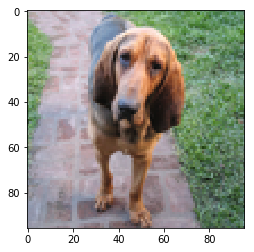

In [8]:
plt.imshow(Xtest.reshape(96, 96, 3))

In [74]:
dists = np.linalg.norm(X_train-Xtest, axis=-1)

In [76]:
dists

array([15551.44816408, 15850.58509961, 14012.93652308, ...,
       18057.01846928, 13830.7731888 , 10964.84099292])

In [79]:
np.sort(dists)

array([ 8152.46907385,  8308.94866996,  8364.6748293 , ...,
       20742.69242408, 20811.59376405, 20971.74041419])

In [80]:
np.argsort(dists)

array([ 956, 1836,  515, ...,   47,  111,  827])

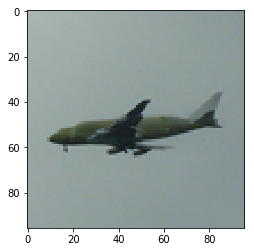

In [85]:
plt.imshow(X_train[515].reshape(96, 96, 3))

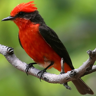

In [92]:
im2 = Image.open('test2.png', 'r')
im2

In [93]:
Xtest2 = np.array(im2.crop((0,0,96,96)).getdata()).reshape(27648,)


In [107]:
dists2 = np.linalg.norm(X_train-Xtest2, axis=1)

In [111]:
dists2

array([14307.21031508, 16645.01898467, 10967.65002177, ...,
       16867.17092461, 10856.00018423, 12252.21290217])

In [114]:
np.argsort(dists2)

array([1382, 1492,  447, ...,   43, 1573, 1369])

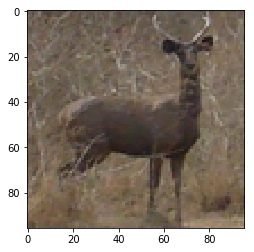

In [117]:
plt.imshow(X_train[447].reshape(96, 96, 3))